# Preparations

In [1]:
import ast
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
# Some parameters of the simulation to be analyzed
rounds = 100
vehicle_limit = 80
all_routes = [[0, 3], [0, 1], [2, 3], [2, 1]]

In [3]:
# Extract the summary data files of the finished simulation
record = pd.read_csv(f'Saved_data/Simulation_records/Round_{rounds}.csv')
utility = pd.read_csv(f'Saved_data/Utility_data/Round_{rounds}.csv')

## Preprocessing of `record`
The dataframe contains vehicle data recorded in each simulation round, including:
- the label assigned to each car (`Vehicle_label`)
- the routes taken (`Road_order`)
- the time spent to reach the end (`Total_time`)
- the label of the vehicle immediately in front of it in the corrdsponding road segment (`Leading_vehicles`)
- the amount of time it stopped (speed is 0) in the corresponding road segment (`Stopped_time`)

In [4]:
# Since some column values are lists, they need to be preprocessed after importing the csv file to
# avoid the lists being recognized as strings
record['Road_order'] = record.apply(lambda row: ast.literal_eval(row['Road_order']), axis=1)

# Add a column that maps a specific road combination (i.e., a route) to a "label", which is its position
# in a list that shows all the possible routes
record["Road_order_label"] = record.apply(lambda row: all_routes.index(row.Road_order), axis=1)

record.head(5)

,Vehicle_label,Road_order,Total_time,Leading_vehicles,Stopped_time,Stop_while_front,Round_number,Road_order_label
0,0,"[2, 3]",67.75,"[-999, -999]","[0, 0]","[0, 0]",1,2
1,1,"[0, 3]",110.60,"[-999, 13]","[0, 0]","[5.999999999999987, 0]",1,0
2,2,"[0, 1]",80.35,"[1, -999]","[0, 0]","[0, 0]",1,1
3,3,"[2, 1]",37.15,"[0, -999]","[0, 0]","[0, 0]",1,3
4,4,"[2, 1]",38.90,"[3, 3]","[0, 0]","[0, 0]",1,3


## Preprocessing of `utility`
The dataframe contains utility data computed based on the simulation outcome, including:
- the label assigned to each car (`Vehicle_label`)
- the utility value of each route as a list element (`Utilities`)
- the probability value of choosing each route in the next round as a list element (`Probabilities`)
- all the routes each car has chosen so far (`Routes_taken`)
- the interpolation between time and money for the driver (`Gamma`) for computing the time component of the utility value
- the risk aversion level of the driver (`Eta`) for deciding the formula of utility calculation

In [5]:
utility['Routes_taken'] = utility.apply(lambda row: ast.literal_eval(row['Routes_taken']), axis=1)
utility['Probabilities'] = utility.apply(lambda row: ast.literal_eval(row['Probabilities']), axis=1)

utility.head(5)

,Vehicle_label,Utilities,Probabilities,Routes_taken,Gamma,Eta
0,0,"[-3.110777524910148, -3.1051345787819273, -1.7...","[0.10453310811110922, 0.10512465025933546, 0.3...","[2, 0, 3, 1, 0, 3, 2, 2, 1, 3, 2, 2, 1, 1, 3, ...",4.910645,0.469342
1,1,"[-3.1701469644484037, -3.0559723250678523, -1....","[0.09754814913413978, 0.10934638993903192, 0.3...","[0, 1, 2, 3, 3, 3, 0, 1, 0, 2, 2, 2, 2, 3, 0, ...",3.826463,0.469338
2,2,"[-2.8811370435073114, -3.398744614262264, -1.8...","[0.13656691485476946, 0.08138631532447294, 0.3...","[1, 3, 2, 0, 2, 2, 0, 2, 3, 3, 0, 2, 3, 2, 3, ...",4.400941,0.487728
3,3,"[-3.0947024074634646, -2.973340440460902, -1.7...","[0.10231947920868333, 0.11552212088425111, 0.3...","[3, 0, 1, 2, 0, 2, 2, 3, 0, 2, 2, 3, 1, 0, 3, ...",4.654804,0.459502
4,4,"[-3.6300840334958675, -3.7582826294301293, -2....","[0.10119945953503562, 0.08902300507698345, 0.3...","[3, 0, 2, 1, 0, 1, 2, 3, 2, 1, 3, 2, 0, 3, 3, ...",5.180746,0.602421


## Functions needed

In [6]:
def route_avg_time(ax, 
                   fig,
                   record_df, 
                   number_of_routes,
                   save_dir=None):
    """
    Plot the average time to arrive grouped by each route and round.
    """
    
    time_df = pd.pivot_table(record, values='Total_time', 
                             index=['Road_order_label', 'Round_number'], 
                             aggfunc=np.mean).reset_index(drop=False)
    plot_route_time = [[], [], [], []]

    for i in range(number_of_routes):
        times = time_df.loc[time_df.Road_order_label==i].sort_values('Round_number').Total_time.values
        plot_route_time[i]=times

    for i in range(number_of_routes):
        ax.plot(plot_route_time[i], label="Route "+str(i))

    ax.set_xlabel("Round")
    ax.set_ylabel("Average time to arrive")
    ax.set_title("Average time needed to reach when taking different routes")
    plt.legend(bbox_to_anchor=(1, 0.5))
    
    if save_dir != None:
        fig.savefig(save_dir, bbox_inches = 'tight')
    
    plt.show()

In [7]:
def total_time_spent(ax, 
                     fig,
                     record_df, 
                     save_dir=None):
    """
    Sum up and plot all the time spent by vehicles in each round    
    """
    
    time_df = pd.pivot_table(record_df, values='Total_time', 
                             index='Round_number', 
                             aggfunc=np.sum).reset_index(drop=False)
    
    ax.plot(time_df.Round_number, time_df.Total_time)
    
    ax.set_xlabel("Round")
    ax.set_ylabel("Total time spent")
    ax.set_title("Sum of time spent by all vehicles over time")
    
    if save_dir != None:
        fig.savefig(save_dir, bbox_inches = 'tight')
    
    plt.show()
    
    return time_df.Total_time.tolist()

In [8]:
def route_taken_number(ax,
                       fig,
                       utility_df, 
                       rounds, 
                       number_of_routes, 
                       save_dir=None):
    """
    Plot the changes in number of vehicles that took the route over time.
    """
    
    route_df = pd.DataFrame(utility_df['Routes_taken'].to_list(), columns=range(rounds))
    plot_route_l = [[], [], [], []]

    for i in range(number_of_routes):
        for j in range(rounds):
            plot_route_l[i].append(len(route_df.loc[route_df[j]==i]))

    for i in range(number_of_routes):
        ax.plot(plot_route_l[i], label="Route "+str(i))
    
    ax.set_xlabel("Round")
    ax.set_ylabel("Number of vehicles choosing the route")
    ax.set_title("Changes in the number of vehicles that choose a route over time")
    plt.legend(bbox_to_anchor=(1, 0.5))
    
    if save_dir != None:
        fig.savefig(save_dir, bbox_inches = 'tight')
    
    plt.show()

In [9]:
def route_chosen_probability(ax,
                             fig,
                             rounds, 
                             number_of_routes, 
                             save_dir=None):
    """
    Plot the changes in probabilities of choosing each route over time.    
    """
    
    plot_prob_l = [[], [], [], []]

    for r in range(1, rounds+1):
        df = pd.read_csv(f'Saved_data/Utility_data/Round_{r}.csv')
        df['Probabilities'] = df.apply(lambda row: ast.literal_eval(row['Probabilities']), axis=1)
        for i in range(number_of_routes):
            avg_prob = pd.DataFrame(df['Probabilities'].to_list(), columns=range(number_of_routes))[i].mean()
            plot_prob_l[i].append(avg_prob)
            
    for i in range(number_of_routes):
        ax.plot(plot_prob_l[i], label="Route "+str(i))

    ax.set_xlabel("Round")
    ax.set_ylabel("Average probability of choosing the route")
    ax.set_title("Changes in the average probability of choosing a route over time")
    plt.legend(bbox_to_anchor=(1, 0.5))
    
    if save_dir != None:
        fig.savefig(save_dir, bbox_inches = 'tight')
    
    plt.show()

In [10]:
def eta_prob_scatter(ax, 
                     fig,
                     utility_df, 
                     number_of_routes, 
                     save_dir=None):
    """
    Plot the relationship between the eta value of each vehicle and their probabilities of
    choosing a specific route.
    """
    
    plot_eta_prob = [[], [], [], []]

    for i in range(number_of_routes):
        plot_eta_prob[i]=pd.DataFrame(utility_df['Probabilities'].to_list(), 
                                      columns=range(number_of_routes))[i].values

    for i in range(number_of_routes):
        ax.scatter(utility_df.Eta.values, plot_eta_prob[i], label="Route "+str(i), alpha=0.5)

    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel("Probability of taking the route")
    ax.set_title(r"Relationship between $\eta$ and the probability of taking each route")
    plt.legend(bbox_to_anchor=(1, 0.5))
    
    if save_dir != None:
        fig.savefig(save_dir, bbox_inches = 'tight')
    
    plt.show()

In [11]:
def gamma_prob_scatter(ax, 
                       fig,
                       utility_df, 
                       number_of_routes, 
                       save_dir=None):
    """
    Plot the relationship between the gamma value of each vehicle and their probabilities of
    choosing a specific route.
    """
    
    plot_gamma_prob = [[], [], [], []]

    for i in range(number_of_routes):
        plot_gamma_prob[i]=pd.DataFrame(utility_df['Probabilities'].to_list(), 
                                      columns=range(number_of_routes))[i].values

    for i in range(number_of_routes):
        ax.scatter(utility_df.Gamma.values, plot_gamma_prob[i], label="Route "+str(i), alpha=0.5)

    ax.set_xlabel(r"$\gamma$")
    ax.set_ylabel("Probability of taking the route")
    ax.set_title(r"Relationship between $\gamma$ and the probability of taking each route")
    plt.legend(bbox_to_anchor=(1, 0.5))
    
    if save_dir != None:
        fig.savefig(save_dir, bbox_inches = 'tight')
    
    plt.show()

In [12]:
def total_utility(ax, 
                  fig,
                  utility_df, 
                  target_number_of_rounds, 
                  rounds, 
                  save_dir=None):
    
    """
    Plot and return the total utility values of all vehicles in each of the last few rounds.
    The number of rounds is specified by 'target_number_of_rounds'.
    """
    
    total_utilities = np.zeros((target_number_of_rounds))
    
    for r in range(rounds-target_number_of_rounds+1, rounds+1):
        df = pd.read_csv(f'Saved_data/Utility_data/Round_{r}.csv')
        df['Utilities'] = df.apply(lambda row: ast.literal_eval(row['Utilities']), axis=1)
        df['Routes_taken'] = df.apply(lambda row: ast.literal_eval(row['Routes_taken']), axis=1)
        
        for idx, row in df.iterrows():
            route_taken = row['Routes_taken'][-1]
            utility = row['Utilities'][route_taken]
            
            total_utilities[r-(rounds-target_number_of_rounds+1)] += utility
    
    ax.plot(range(rounds-target_number_of_rounds+1, rounds+1), total_utilities)
    
    ax.set_xlabel("Round")
    ax.set_ylabel("Total utilities")
    ax.set_title("Total utilities of all vehicles over time")
    
    if save_dir != None:
        fig.savefig(save_dir, bbox_inches = 'tight')
    
    plt.show()
    
    return total_utilities

# Analysis

## - The average time needed to reach destination by different routes

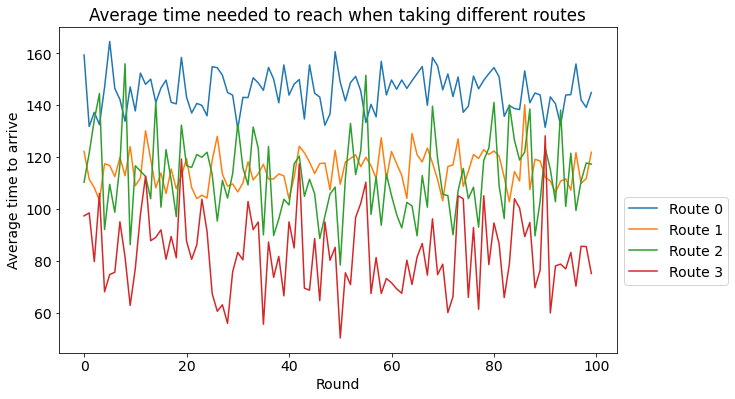

In [13]:
fig1, ax1 = plt.subplots(figsize=(10, 6))

route_avg_time(ax1, 
               fig1,
               record_df=record, 
               number_of_routes=len(all_routes),
               save_dir="Route_Avg_Time.png"
              )

## - The total time spent by all vehicles to reach destination

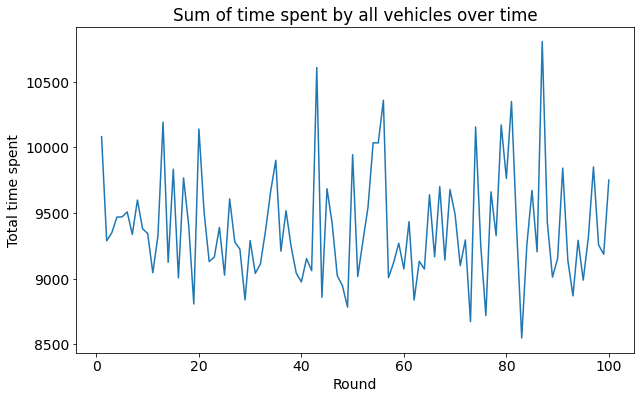

The average total time spent in the last 25 rounds is 9437.74


In [14]:
fig2, ax2 = plt.subplots(figsize=(10, 6))
total_times = total_time_spent(ax2, 
                               fig2, 
                               record, 
                               save_dir="Total_Time.png"
                              )

target_number_of_rounds = 25
target_list = total_times[-target_number_of_rounds:]
print(f"The average total time spent in the last {target_number_of_rounds} rounds is {round(sum(target_list)/len(target_list), 2)}")

## - The number of vehicles that choose a route over time

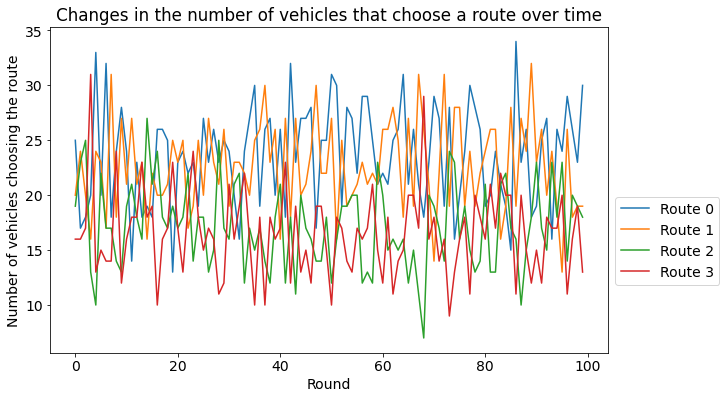

In [15]:
fig3, ax3 = plt.subplots(figsize=(10, 6))

route_taken_number(ax3, 
                   fig3, 
                   utility, 
                   rounds, 
                   len(all_routes),
                   save_dir="Route_Chosen_Times.png"
                  )

## - The probabilities of choosing different routes over time

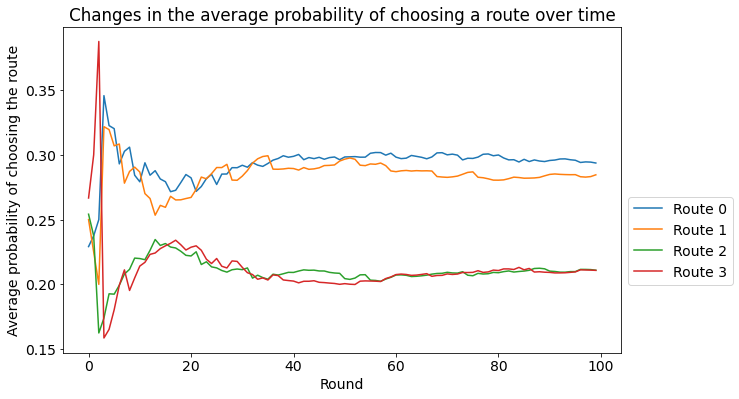

In [16]:
fig4, ax4 = plt.subplots(figsize=(10, 6))

route_chosen_probability(ax4, 
                         fig4,
                         rounds, 
                         len(all_routes),
                         save_dir="Route_Avg_Prob.png"
                        )

## - The relationship between $\eta$ and the probability of taking a route

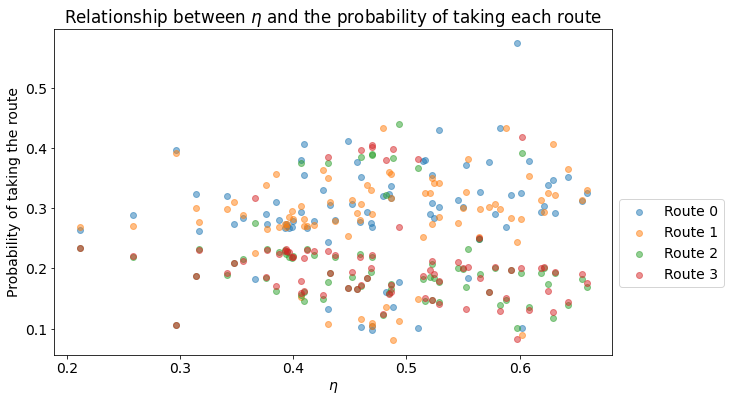

In [17]:
fig5, ax5 = plt.subplots(figsize=(10, 6))

eta_prob_scatter(ax5, 
                 fig5,
                 utility, 
                 len(all_routes),
                 save_dir="Eta_Vs_Prob.png"
                )

## - The relationship between $\gamma$ and the probability of taking a route

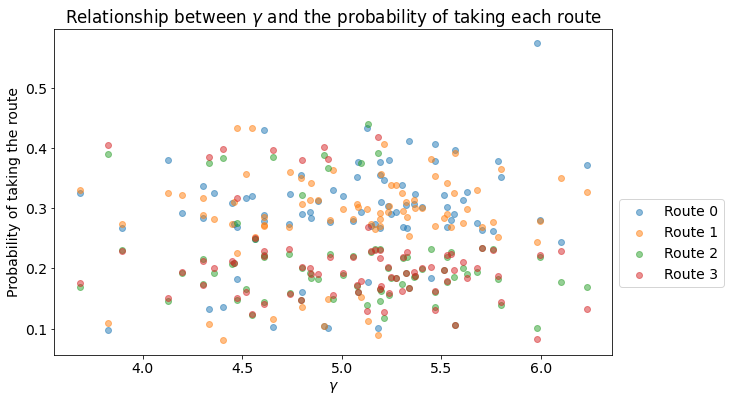

In [18]:
fig6, ax6 = plt.subplots(figsize=(10, 6))

gamma_prob_scatter(ax6, 
                   fig6,
                   utility,
                   len(all_routes),
                   save_dir="Gamma_Vs_Prob.png"
                  )

## - The total utilities of all vehicles in the last few rounds

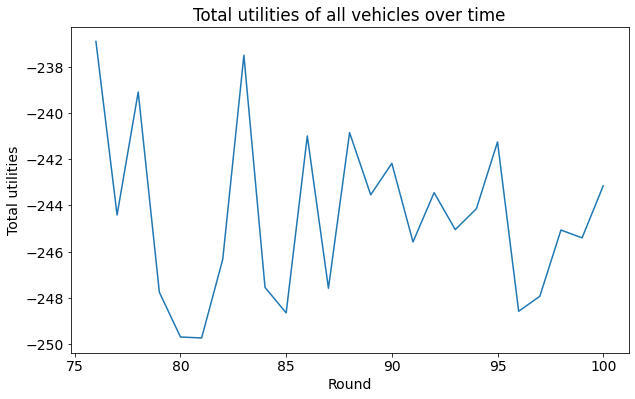

The average total utilities in the last 25 rounds is -244


In [19]:
fig7, ax7 = plt.subplots(figsize=(10, 6))

target_number_of_rounds = 25
total_utilities = total_utility(ax7, 
                                fig7,
                                utility, 
                                target_number_of_rounds, 
                                rounds,
                                save_dir="Total_Utilities.png"
                               )
print(f"The average total utilities in the last {target_number_of_rounds} rounds is {round(sum(total_utilities)/target_number_of_rounds)}")